In the previous post, I showed how to solve inverse problems for coefficients of elliptic PDE using [firedrake-adjoint](http://www.dolfin-adjoint.org/en/latest/).
The exact parameter field that I used in that demonstration was smooth in space and, to guarantee a smooth solution, I showed how to add regularization to the objective functional.
Many geophysical inverse problems aim to estimate fields that instead have sharp discontinuities or interfaces.
For example, the porosity of soil and hard bedrock are very different and there is no continuous transition between the two.
For these media, the regularization functional

$$R(q) = \frac{1}{2}\int_\Omega|\nabla q|^2 dx$$

that we used in that demonstration would yield an infinite value.
The inferred field with this penalty would have a more diffuse interface than the real one.

Rather than use the integrated square gradient, we can instead use the **total variation** functional:

$$R(q) = \int_\Omega|\nabla q|dx.$$

We can get some insight into why the total variation is a good regularizer for these types of problems by using the very wonderful [coarea formula](https://en.wikipedia.org/wiki/Coarea_formula).
The coarea formula states that, for reasonable functions $p$ and $q$, we can express certain integrals involving the gradient of $q$ in terms of its contours or level sets.
Let $ds$ be the element of surface area, let $z$ be an arbitrary real value, and let $\Gamma_z$ be the $z$-contour surface of the function $q$.
Then

$$\int_\Omega p|\nabla q|dx = \int_{-\infty}^\infty\int_{\Gamma_z}p\, ds\, dz.$$

The right-hand side of the last equation can make sense even when $q$ is discontinuous, provided we're a little careful in the definition of the $z$-contour of $q$:

$$\Gamma_z = \partial\{x \in \Omega: q(x) \le z\}.$$

For example, suppose that $\Gamma$ is some nice closed surface inside $\Omega$, and we take $q$ to be equal to $\alpha$ in the interior of $\Gamma$ and $0$ outside.
Then the coarea formula tells us that

$$\int_\Omega|\nabla q|dx = a\cdot|\Gamma|.$$

This partly explains why the total variation functional is an effective regularizer.
While it doesn't forbid a jump discontinuity as such, it instead penalizes (1) the magnitude of the jump and (2) the area of the surface over which it occurs.
Gabriel Peyré has a nice visualization of the coarea formula on [Twitter](https://twitter.com/gabrielpeyre/status/985768327246237697).

### Calculating total variation

A new difficulty that we'll encounter here is that the total variation functional doesn't have a well-defined functional derivative like the mean square gradient does.
It is a convex functional, so the minimum is well-defined, but we might be at a loss for an algorithm to actually approximate it.

We've already encountered the mathematical concepts that we'll need to remedy this issue in a previous post on the obstacle problem.
The obstacle problem is the prototypical example of an optimization problem with inequality constraints.
To solve it, we reformulated the obstacle problem as an unconstrained convex optimization problem where the objective could take the value $+\infty$.
We then smoothed away the infinite values by instead working with the Moreau envelope of that functional.

Many of the same tricks work for total variation-type problems because the Moreau envelope of the $L^1$-norm has a simple analytical expression in terms of the *Huber function*:

$$H_\gamma(z) = \begin{cases}\frac{1}{2\gamma}|z|^2 & |z| < \gamma \\ |z| - \frac{\gamma}{2} & |z| \ge \gamma \end{cases}$$

The Huber function looks like the $L^1$ norm for large values of the argument, but like the square norm for small values.

In [1]:
import numpy as np
zs = np.linspace(-5., 5., 41)
γ = 2.
H_γ = [z**2 / (2 * γ) if abs(z) < γ else abs(z) - γ / 2 for z in zs]

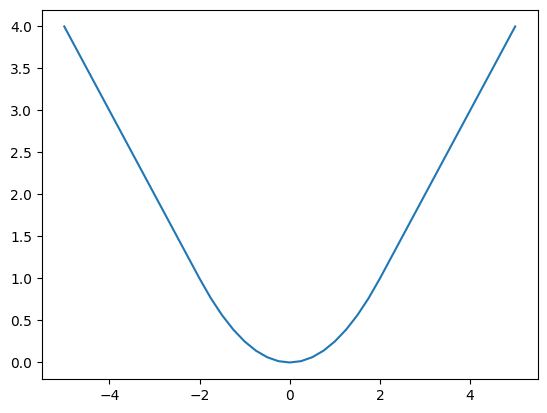

In [2]:
import matplotlib.pyplot as plt
plt.plot(zs, H_γ);

The Moreau envelope of the 1-norm can be expressed through the Huber function.
Suppose that $z$ and $w$ are vector fields in the space $L^2(\Omega)$; then

$$\inf_w\left(\int_\Omega|w|dx + \frac{1}{2\gamma}\int_\Omega|z - w|^2dx\right) = \int_\Omega H_\gamma(z)dx.$$

This Huber functional does have a well-defined functional derivative for positive values of the penalty parameter $\gamma$, so we can reuse our old gradient-based optimization routines.
As with any penalty-type method, however, the problem becomes more ill-conditioned as we decrease $\gamma$.
There's one more critical fact we'll need.
We know how to calculate the Moreau envelope of the 1-norm, but our regularization functional is instead a scalar multiple of the 1-norm.
If we denote the envelope of a functional $R$ by $\text{env}_\gamma R$, then

$$\text{env}_\gamma\, \alpha\cdot R = \alpha\cdot\text{env}_{\gamma\alpha}R.$$

With this identity in hand, we can instead try to minimize the approximate objective functional

$$J_\gamma(u, q) = \frac{1}{2}\int_\Omega\left(\frac{u - u^o}{\sigma}\right)^2dx + \alpha\int_\Omega H_{\alpha\gamma}\left(\nabla q\right)\,dx.$$

Letting $F$ be the weak form of the Poisson equation, our constraint is that

$$\langle F(u, q), v\rangle = 0$$

for all test functions $v$.
Recall that the scalar parameter $\alpha$ that dictates the degree to which we're regularizing the problem, and has units of $[q]^{-1}\cdot[x]$.
When we were using the mean square gradient to regularize the problem, this quantity was raised to the power 2 to make the units work out correctly.
Here the exponent is 1 instead.
Moreover, we can make an educated guess for what $\alpha$ might be if we know roughly the numerical range of the field we're inferring and the diameter of the domain.

### Generating the exact data

We'll proceed much like we did in the last post, only the conductivity field will have a sharp interface such as one might find between two distinct media.
To make things a little easier later, we'll actually use a continuous Galerkin basis, in which case the interface will extend over a single grid cell.
This is a little bit sinful and really we should be using a DG basis.
But that would involve a bunch of annoying facet integrals that distract from the real point.
We can just as easily illustrate the essential idea using continuous basis functions.

In [3]:
import firedrake
mesh = firedrake.UnitSquareMesh(32, 32, diagonal='crossed')
Q = firedrake.FunctionSpace(mesh, family='CG', degree=2)
V = firedrake.FunctionSpace(mesh, family='CG', degree=2)

In [4]:
from numpy import random, pi as π
x = firedrake.SpatialCoordinate(mesh)

rng = random.default_rng(seed=1)
def random_fourier_series(std_dev, num_modes, exponent):
    from firedrake import sin, cos
    A = std_dev * rng.standard_normal((num_modes, num_modes))
    B = std_dev * rng.standard_normal((num_modes, num_modes))
    return sum([(A[k, l] * sin(π * (k * x[0] + l * x[1])) +
                 B[k, l] * cos(π * (k * x[0] + l * x[1])))
                / (1 + (k**2 + l**2)**(exponent/2))
                for k in range(num_modes)
                for l in range(int(np.sqrt(num_modes**2 - k**2)))])

In [5]:
g = firedrake.Function(V).interpolate(random_fourier_series(1.0, 6, 1))

In [6]:
from firedrake import inner, max_value, conditional, Constant
a = -Constant(4.5)
r = Constant(1/4)
ξ = Constant((0.4, 0.5))
expr = a * conditional(inner(x - ξ, x - ξ) < r**2, 1, 0)
q_true = firedrake.Function(Q).interpolate(expr)

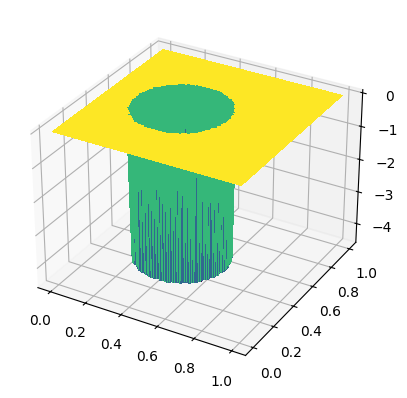

In [7]:
firedrake.trisurf(q_true);

In [8]:
b = Constant(6.)
R = Constant(1/4)
η = Constant((0.7, 0.5))
expr = b * max_value(0, 1 - inner(x - η, x - η) / R**2)
f = firedrake.Function(V).interpolate(expr)

In [9]:
from firedrake import exp, grad, dx, ds
k = Constant(1.)
h = Constant(10.)
u_true = firedrake.Function(V)
v = firedrake.TestFunction(V)
F = (
    (k * exp(q_true) * inner(grad(u_true), grad(v)) - f * v) * dx +
    h * (u_true - g) * v * ds
)

In [10]:
opts = {
    'solver_parameters': {
        'ksp_type': 'preonly',
        'pc_type': 'lu',
        'pc_factor_mat_solver_type': 'mumps'
    }
}
firedrake.solve(F == 0, u_true, **opts)

The true solution shares many properties with that of the previous demo, namely the sharp spike in the middle of the domain where the medium becomes more insulating.
An interesting feature you can see here is how there's a break in slope across the discontinuity.
This is a general feature of sharp interface problems; the flux is discontinuous, even though the gradient of the solution is not.

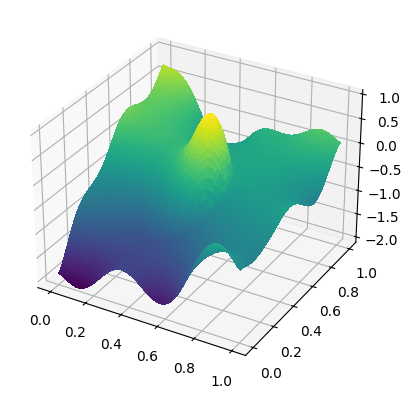

In [11]:
firedrake.trisurf(u_true);

### Generating the observational data

To create the synthetic observations, we'll proceed along the same lines as in the last post.
Recall that these incantations were necessary because generating a random field with the correct error statistics using a finite element basis does all sorts of weird unintuitive things.

In [12]:
ξ = firedrake.Function(V)
n = len(ξ.dat.data_ro)
ξ.dat.data[:] = rng.standard_normal(n)

In [13]:
from firedrake import assemble
from firedrake.petsc import PETSc
ϕ, ψ = firedrake.TrialFunction(V), firedrake.TestFunction(V)
m = inner(ϕ, ψ) * dx
M = assemble(m, mat_type='aij').M.handle
ksp = PETSc.KSP().create()
ksp.setOperators(M)
ksp.setUp()
pc = ksp.pc
pc.setType(pc.Type.CHOLESKY)
pc.setFactorSolverType(PETSc.Mat.SolverType.PETSC)
pc.setFactorSetUpSolverType()
L = pc.getFactorMatrix()
pc.setUp()

In [14]:
area = assemble(Constant(1) * dx(mesh))

In [15]:
z = firedrake.Function(V)
z.dat.data[:] = rng.standard_normal(n)
with z.dat.vec_ro as Z:
    with ξ.dat.vec as Ξ:
        L.solveBackward(Z, Ξ)
        Ξ *= np.sqrt(area / n)

In [16]:
û = u_true.dat.data_ro[:]
signal = û.max() - û.min()
signal_to_noise = 50
σ = firedrake.Constant(signal / signal_to_noise)

u_obs = u_true.copy(deepcopy=True)
u_obs += σ * ξ

### Solution via Moreau envelopes

We will again use the blunt initial guess that $q = 0$ everywhere.

In [17]:
import firedrake.adjoint
from firedrake.adjoint import (
    Control, ReducedFunctional, MinimizationProblem, ROLSolver
)
firedrake.adjoint.continue_annotation()

True

In [18]:
q = firedrake.Function(Q)
u = firedrake.Function(V)
F = (
    (k * exp(q) * inner(grad(u), grad(v)) - f * v) * dx +
    h * (u - g) * v * ds
)
firedrake.solve(F == 0, u, **opts)

Once again, the initial computed solution lacks the large spike in the insulating part of the medium.

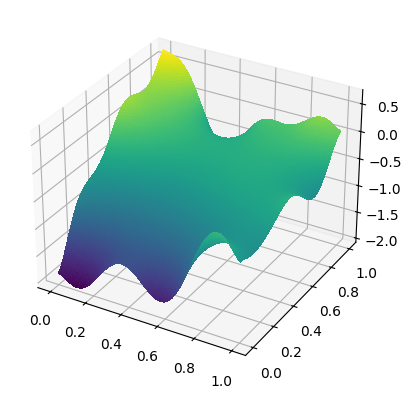

In [19]:
firedrake.trisurf(u);

The Huber functional is easy to express in UFL.
Before writing this, I tried to find a few different ways to express the Huber functional in a way that might be more amenable to symbolic differentiation because I thought that the conditional would prove to be a huge problem.
None of those worked out mathematically, but to my surprise, it seems as if Firedrake can still calculate functional derivatives of conditional expressions just fine.

In [20]:
from firedrake import sqrt
def huber(v, γ):
    return firedrake.conditional(
        inner(v, v) < γ**2,
        inner(v, v) / (2 * γ),
        sqrt(inner(v, v)) - γ / 2
    )

We'll use the same value $\alpha$ for the smoothing length as in the previous demo, noting again that it's to the power of 1 instead of 2 this time.
But we don't have much in the way of a priori guidance for how to pick the Moreau envelope parameter $\gamma$, which should be dimensionless.
I arrived at the following value by trial and error.

In [21]:
α = Constant(5e-2)
γ = Constant(4e2)

J = assemble(
    0.5 * ((u - u_obs) / σ)**2 * dx +
    α * huber(grad(q), α * γ) * dx
)

The procedure to compute the solution works just the same as before.

In [22]:
rol_options = {
    "Step": {
        "Type": "Line Search",
        "Line Search": {"Descent Method": {"Type": "Quasi-Newton Step"}},
    },
    "Status Test": {
        "Gradient Tolerance": 1e-4,
        "Step Tolerance": 1e-4,
        "Iteration Limit": 500,
    },
    "General": {
        "Print Verbosity": 0,
        "Secant": {"Type": "Limited-Memory BFGS", "Maximum Storage": 10},
    },
}

In [23]:
q̂ = Control(q)
Ĵ = ReducedFunctional(J, q̂)
inverse_problem = MinimizationProblem(Ĵ)
inverse_solver = ROLSolver(inverse_problem, rol_options, inner_product="L2")
q_γ = inverse_solver.solve()


Quasi-Newton Method with Limited-Memory BFGS
Line Search: Cubic Interpolation satisfying Strong Wolfe Conditions
  iter  value          gnorm          snorm          #fval     #grad     ls_#fval  ls_#grad  
  0     9.643037e+00   1.399841e+01   


  1     7.151756e+00   1.327846e+01   6.999207e-01   4         2         3         0         


  2     5.317752e+00   7.769658e+00   2.344501e-01   5         3         1         0         


  3     5.177837e+00   1.308081e+01   9.425884e-02   7         4         2         0         


  4     4.870890e+00   7.694530e+00   7.382621e-02   8         5         1         0         


  5     4.770989e+00   8.740934e+00   8.846656e-02   9         6         1         0         


  6     4.653254e+00   4.835791e+00   2.985622e-02   10        7         1         0         


  7     4.518833e+00   7.020358e+00   7.129854e-02   11        8         1         0         


  8     4.325283e+00   8.569662e+00   1.065764e-01   12        9         1         0         


  9     4.174223e+00   1.448035e+01   3.580487e-01   13        10        1         0         


  10    3.910536e+00   1.064447e+01   5.194910e-02   14        11        1         0         


  11    3.788338e+00   6.814474e+00   7.769694e-02   15        12        1         0         


  12    3.703465e+00   4.668926e+00   5.541587e-02   16        13        1         0         


  13    3.648337e+00   4.210390e+00   5.129721e-02   17        14        1         0         


  14    3.571525e+00   4.812413e+00   1.086629e-01   18        15        1         0         


  15    3.497052e+00   6.515059e+00   6.931202e-02   19        16        1         0         


  16    3.393292e+00   5.710241e+00   5.999105e-02   20        17        1         0         


  17    3.269236e+00   9.639708e+00   1.919149e-01   21        18        1         0         


  18    3.170757e+00   7.038664e+00   6.204242e-02   22        19        1         0         


  19    3.122246e+00   3.889206e+00   3.142054e-02   23        20        1         0         


  20    3.072728e+00   3.463779e+00   2.175325e-02   24        21        1         0         


  21    3.016859e+00   4.897904e+00   5.055309e-02   25        22        1         0         


  22    2.955648e+00   5.554341e+00   8.923672e-02   26        23        1         0         


  23    2.901716e+00   4.575460e+00   9.030657e-02   27        24        1         0         


  24    2.857833e+00   3.337754e+00   2.453605e-02   28        25        1         0         


  25    2.814691e+00   4.199245e+00   3.912901e-02   29        26        1         0         


  26    2.768455e+00   4.669951e+00   4.989265e-02   30        27        1         0         


  27    2.698434e+00   3.889710e+00   9.763367e-02   31        28        1         0         


  28    2.648716e+00   5.107549e+00   8.463428e-02   32        29        1         0         


  29    2.600372e+00   3.938509e+00   3.807207e-02   33        30        1         0         


  30    2.543775e+00   3.992180e+00   5.355833e-02   34        31        1         0         


  31    2.495133e+00   4.803032e+00   6.454375e-02   35        32        1         0         


  32    2.435117e+00   4.066342e+00   7.654279e-02   36        33        1         0         


  33    2.365653e+00   4.590124e+00   8.473086e-02   37        34        1         0         


  34    2.286880e+00   5.504713e+00   9.289334e-02   38        35        1         0         


  35    2.197781e+00   5.494823e+00   7.756436e-02   39        36        1         0         


  36    2.102317e+00   5.502872e+00   6.887699e-02   40        37        1         0         


  37    2.019258e+00   5.057915e+00   5.630359e-02   41        38        1         0         


  38    1.992248e+00   5.902307e+00   9.160900e-02   42        39        1         0         


  39    1.928475e+00   7.018505e+00   9.612063e-02   43        40        1         0         


  40    1.857890e+00   6.579460e+00   3.903594e-02   44        41        1         0         


  41    1.811389e+00   3.251421e+00   2.525938e-02   45        42        1         0         


  42    1.772268e+00   3.244284e+00   4.208240e-02   46        43        1         0         


  43    1.721769e+00   3.959765e+00   5.807517e-02   47        44        1         0         


  44    1.681262e+00   6.890308e+00   9.484117e-02   48        45        1         0         


  45    1.624934e+00   3.779125e+00   3.399943e-02   49        46        1         0         


  46    1.589240e+00   3.366120e+00   2.406101e-02   50        47        1         0         


  47    1.555533e+00   3.592292e+00   3.799165e-02   51        48        1         0         


  48    1.520846e+00   4.020307e+00   5.826334e-02   52        49        1         0         


  49    1.488913e+00   3.097290e+00   4.158360e-02   53        50        1         0         


  50    1.464794e+00   2.678685e+00   2.423729e-02   54        51        1         0         


  51    1.442222e+00   2.890086e+00   2.473525e-02   55        52        1         0         


  52    1.414858e+00   3.320784e+00   4.116577e-02   56        53        1         0         


  53    1.389838e+00   3.008880e+00   3.227337e-02   57        54        1         0         


  54    1.366282e+00   2.447147e+00   2.170830e-02   58        55        1         0         


  55    1.344419e+00   2.608150e+00   2.832654e-02   59        56        1         0         


  56    1.325857e+00   2.705907e+00   2.584774e-02   60        57        1         0         


  57    1.308764e+00   2.076034e+00   1.855503e-02   61        58        1         0         


  58    1.293110e+00   2.125585e+00   2.539770e-02   62        59        1         0         


  59    1.280211e+00   2.822731e+00   2.585309e-02   63        60        1         0         


  60    1.263894e+00   2.152095e+00   2.541056e-02   64        61        1         0         


  61    1.249549e+00   2.791509e+00   2.898650e-02   65        62        1         0         


  62    1.238607e+00   2.078566e+00   1.711813e-02   66        63        1         0         


  63    1.227561e+00   1.879708e+00   1.163722e-02   67        64        1         0         


  64    1.215317e+00   2.059994e+00   2.878383e-02   68        65        1         0         


  65    1.205027e+00   1.977711e+00   2.165862e-02   69        66        1         0         


  66    1.192295e+00   1.711295e+00   2.414215e-02   70        67        1         0         


  67    1.181258e+00   2.012300e+00   2.618131e-02   71        68        1         0         


  68    1.171733e+00   1.981793e+00   1.646020e-02   72        69        1         0         


  69    1.162401e+00   1.619375e+00   1.333564e-02   73        70        1         0         


  70    1.152582e+00   1.824472e+00   2.243329e-02   74        71        1         0         


  71    1.143237e+00   2.111050e+00   3.022285e-02   75        72        1         0         


  72    1.134196e+00   1.509767e+00   1.427936e-02   76        73        1         0         


  73    1.126595e+00   1.505194e+00   1.936367e-02   77        74        1         0         


  74    1.119809e+00   1.587592e+00   1.570490e-02   78        75        1         0         


  75    1.112269e+00   1.430254e+00   2.165754e-02   79        76        1         0         


  76    1.106872e+00   1.796468e+00   1.527934e-02   80        77        1         0         


  77    1.102036e+00   1.159134e+00   7.019110e-03   81        78        1         0         


  78    1.097349e+00   1.156446e+00   1.123298e-02   82        79        1         0         


  79    1.092171e+00   1.406929e+00   1.608984e-02   83        80        1         0         


  80    1.086251e+00   1.848161e+00   3.059599e-02   84        81        1         0         


  81    1.079938e+00   1.344995e+00   1.411213e-02   85        82        1         0         


  82    1.074886e+00   1.217271e+00   9.474355e-03   86        83        1         0         


  83    1.069358e+00   1.421784e+00   1.814758e-02   87        84        1         0         


  84    1.063439e+00   1.505154e+00   2.547418e-02   88        85        1         0         


  85    1.057365e+00   1.315471e+00   1.693717e-02   89        86        1         0         


  86    1.051142e+00   1.387245e+00   2.182090e-02   90        87        1         0         


  87    1.045659e+00   1.722487e+00   1.449172e-02   91        88        1         0         


  88    1.039808e+00   1.206389e+00   1.009896e-02   92        89        1         0         


  89    1.034339e+00   1.321725e+00   2.077977e-02   93        90        1         0         


  90    1.030497e+00   1.488533e+00   1.149547e-02   94        91        1         0         


  91    1.026947e+00   1.012325e+00   6.460758e-03   95        92        1         0         


  92    1.022916e+00   9.922818e-01   1.611247e-02   96        93        1         0         


  93    1.020087e+00   1.157140e+00   1.314076e-02   97        94        1         0         


  94    1.016420e+00   9.670154e-01   1.914793e-02   98        95        1         0         


  95    1.013595e+00   1.089741e+00   1.555007e-02   99        96        1         0         


  96    1.010959e+00   9.036787e-01   7.596261e-03   100       97        1         0         


  97    1.007067e+00   1.031272e+00   1.484185e-02   101       98        1         0         


  98    1.002084e+00   1.557687e+00   2.583516e-02   102       99        1         0         


  99    9.975496e-01   1.479950e+00   3.334588e-02   103       100       1         0         


  100   9.920066e-01   1.140847e+00   8.854193e-03   104       101       1         0         


  101   9.866522e-01   1.177012e+00   1.365927e-02   105       102       1         0         


  102   9.829571e-01   1.474006e+00   1.673259e-02   106       103       1         0         


  103   9.786496e-01   9.693191e-01   1.048204e-02   107       104       1         0         


  104   9.750124e-01   1.066010e+00   1.440085e-02   108       105       1         0         


  105   9.719906e-01   1.300671e+00   1.223089e-02   109       106       1         0         


  106   9.687339e-01   1.012853e+00   1.114952e-02   110       107       1         0         


  107   9.643719e-01   1.228240e+00   2.519163e-02   111       108       1         0         


  108   9.615411e-01   1.266536e+00   1.332406e-02   112       109       1         0         


  109   9.590224e-01   9.974874e-01   5.224666e-03   113       110       1         0         


  110   9.545629e-01   1.038630e+00   2.088860e-02   114       111       1         0         


  111   9.523858e-01   1.536478e+00   1.761349e-02   115       112       1         0         


  112   9.498992e-01   9.460074e-01   3.180667e-03   116       113       1         0         


  113   9.458206e-01   8.498915e-01   1.505589e-02   117       114       1         0         


  114   9.432515e-01   9.600044e-01   1.289935e-02   118       115       1         0         


  115   9.389511e-01   1.827809e+00   3.451028e-02   119       116       1         0         


  116   9.348259e-01   1.088370e+00   2.054156e-02   120       117       1         0         


  117   9.318446e-01   9.015821e-01   8.022964e-03   121       118       1         0         


  118   9.269506e-01   1.211313e+00   1.853393e-02   122       119       1         0         


  119   9.250270e-01   1.883678e+00   2.121629e-02   123       120       1         0         


  120   9.216443e-01   8.673603e-01   3.827567e-03   124       121       1         0         


  121   9.191150e-01   7.801929e-01   1.003323e-02   125       122       1         0         


  122   9.169890e-01   8.856220e-01   9.453066e-03   126       123       1         0         


  123   9.140876e-01   1.292211e+00   2.397048e-02   127       124       1         0         


  124   9.117742e-01   1.264196e+00   1.466837e-02   128       125       1         0         


  125   9.095843e-01   7.011185e-01   5.410238e-03   129       126       1         0         


  126   9.073996e-01   7.245819e-01   7.682728e-03   130       127       1         0         


  127   9.050538e-01   1.009978e+00   1.343221e-02   131       128       1         0         


  128   9.012634e-01   1.284161e+00   2.600981e-02   132       129       1         0         


  129   8.969851e-01   9.904918e-01   3.003285e-02   133       130       1         0         


  130   8.935150e-01   1.099906e+00   2.396479e-02   134       131       1         0         


  131   8.902260e-01   1.148783e+00   1.069985e-02   135       132       1         0         


  132   8.873623e-01   8.258640e-01   6.249220e-03   136       133       1         0         


  133   8.844524e-01   8.803509e-01   1.596641e-02   137       134       1         0         


  134   8.819115e-01   1.014846e+00   9.525405e-03   138       135       1         0         


  135   8.789315e-01   1.024101e+00   1.423010e-02   139       136       1         0         


  136   8.760454e-01   1.098329e+00   2.093952e-02   140       137       1         0         


  137   8.734223e-01   8.834685e-01   1.012982e-02   141       138       1         0         


  138   8.703453e-01   9.114101e-01   1.114874e-02   142       139       1         0         


  139   8.681565e-01   1.410520e+00   2.830650e-02   143       140       1         0         


  140   8.656973e-01   8.938312e-01   7.537386e-03   144       141       1         0         


  141   8.638933e-01   6.605260e-01   4.076152e-03   145       142       1         0         


  142   8.622212e-01   7.437118e-01   1.155227e-02   146       143       1         0         


  143   8.599319e-01   1.067510e+00   1.516333e-02   147       144       1         0         


  144   8.574618e-01   9.531751e-01   1.453383e-02   148       145       1         0         


  145   8.551154e-01   7.577590e-01   1.357667e-02   149       146       1         0         


  146   8.516668e-01   1.081233e+00   1.890406e-02   150       147       1         0         


  147   8.490171e-01   1.334033e+00   1.913497e-02   151       148       1         0         


  148   8.460644e-01   8.902686e-01   9.478197e-03   152       149       1         0         


  149   8.430613e-01   7.858218e-01   1.326903e-02   153       150       1         0         


  150   8.407258e-01   9.322206e-01   1.135574e-02   154       151       1         0         


  151   8.378016e-01   9.094780e-01   1.739619e-02   155       152       1         0         


  152   8.353133e-01   1.027863e+00   2.305537e-02   156       153       1         0         


  153   8.327754e-01   8.437616e-01   7.847781e-03   157       154       1         0         


  154   8.305587e-01   8.494194e-01   1.065673e-02   158       155       1         0         


  155   8.286292e-01   8.401853e-01   7.693778e-03   159       156       1         0         


  156   8.267885e-01   7.137303e-01   9.502915e-03   160       157       1         0         


  157   8.247164e-01   8.154752e-01   1.300152e-02   161       158       1         0         


  158   8.230263e-01   1.017298e+00   9.664021e-03   162       159       1         0         


  159   8.213648e-01   6.672079e-01   5.181752e-03   163       160       1         0         


  160   8.195875e-01   7.061358e-01   1.087618e-02   164       161       1         0         


  161   8.172510e-01   9.643706e-01   1.560076e-02   165       162       1         0         


  162   8.143790e-01   1.214185e+00   3.098363e-02   166       163       1         0         


  163   8.118811e-01   1.017884e+00   1.561464e-02   167       164       1         0         


  164   8.096652e-01   7.620964e-01   5.763523e-03   168       165       1         0         


  165   8.075968e-01   8.815856e-01   1.366962e-02   169       166       1         0         


  166   8.057183e-01   1.255195e+00   1.258146e-02   170       167       1         0         


  167   8.032639e-01   7.731891e-01   8.442302e-03   171       168       1         0         


  168   8.007095e-01   8.308969e-01   1.941877e-02   172       169       1         0         


  169   7.986884e-01   9.810513e-01   7.613913e-03   173       170       1         0         


  170   7.956114e-01   9.891305e-01   1.888062e-02   174       171       1         0         


  171   7.934224e-01   9.872961e-01   1.804605e-02   175       172       1         0         


  172   7.916216e-01   6.824050e-01   4.179060e-03   176       173       1         0         


  173   7.897502e-01   7.728818e-01   1.383220e-02   177       174       1         0         


  174   7.877251e-01   9.173694e-01   1.194903e-02   178       175       1         0         


  175   7.854809e-01   9.133062e-01   1.763099e-02   179       176       1         0         


  176   7.836633e-01   7.527397e-01   7.401239e-03   180       177       1         0         


  177   7.821392e-01   6.720911e-01   5.130320e-03   181       178       1         0         


  178   7.802077e-01   8.102901e-01   1.529573e-02   182       179       1         0         


  179   7.789433e-01   7.895398e-01   1.025599e-02   183       180       1         0         


  180   7.776785e-01   6.183219e-01   5.417826e-03   184       181       1         0         


  181   7.758457e-01   6.966399e-01   1.040616e-02   185       182       1         0         


  182   7.743362e-01   9.025940e-01   1.241519e-02   186       183       1         0         


  183   7.724521e-01   7.055210e-01   1.332314e-02   187       184       1         0         


  184   7.705570e-01   7.516085e-01   1.775266e-02   188       185       1         0         


  185   7.691531e-01   1.007543e+00   1.028934e-02   189       186       1         0         


  186   7.677036e-01   6.400188e-01   3.086970e-03   190       187       1         0         


  187   7.663515e-01   6.513984e-01   7.967639e-03   191       188       1         0         


  188   7.650923e-01   7.932668e-01   7.372866e-03   192       189       1         0         


  189   7.633326e-01   8.352817e-01   1.593241e-02   193       190       1         0         


  190   7.613840e-01   9.066124e-01   1.736237e-02   194       191       1         0         


  191   7.600198e-01   6.345001e-01   6.087206e-03   195       192       1         0         


  192   7.589032e-01   6.121522e-01   8.740961e-03   196       193       1         0         


  193   7.579878e-01   1.011405e+00   1.048863e-02   197       194       1         0         


  194   7.565553e-01   8.658466e-01   1.180198e-02   198       195       1         0         


  195   7.554588e-01   5.078274e-01   4.971852e-03   199       196       1         0         


  196   7.545304e-01   5.483053e-01   6.327024e-03   200       197       1         0         


  197   7.534752e-01   6.350163e-01   7.956154e-03   201       198       1         0         


  198   7.526291e-01   8.254585e-01   1.725198e-02   202       199       1         0         


  199   7.515534e-01   5.021964e-01   4.193932e-03   203       200       1         0         


  200   7.506780e-01   5.284313e-01   3.690883e-03   204       201       1         0         


  201   7.494858e-01   6.810419e-01   9.863739e-03   205       202       1         0         


  202   7.487047e-01   9.493566e-01   1.207804e-02   206       203       1         0         


  203   7.473293e-01   5.912120e-01   8.457267e-03   207       204       1         0         


  204   7.462713e-01   6.054222e-01   3.921143e-03   208       205       1         0         


  205   7.451675e-01   6.859492e-01   1.272087e-02   209       206       1         0         


  206   7.440814e-01   9.511493e-01   1.450567e-02   210       207       1         0         


  207   7.425632e-01   6.103705e-01   5.475798e-03   211       208       1         0         


  208   7.415736e-01   5.382553e-01   4.921658e-03   212       209       1         0         


  209   7.406372e-01   6.086092e-01   8.624876e-03   213       210       1         0         


  210   7.398980e-01   6.619633e-01   1.309916e-02   214       211       1         0         


  211   7.389859e-01   5.012599e-01   3.787069e-03   215       212       1         0         


  212   7.383784e-01   4.309843e-01   4.754861e-03   216       213       1         0         


  213   7.378112e-01   4.139731e-01   5.057684e-03   217       214       1         0         


  214   7.372588e-01   5.365668e-01   1.195251e-02   218       215       1         0         


  215   7.366384e-01   5.501862e-01   4.884343e-03   219       216       1         0         


  216   7.359897e-01   4.740467e-01   5.455762e-03   220       217       1         0         


  217   7.351361e-01   4.537824e-01   9.733816e-03   221       218       1         0         


  218   7.345408e-01   5.886147e-01   1.099637e-02   222       219       1         0         


  219   7.336686e-01   4.719640e-01   4.673296e-03   223       220       1         0         


  220   7.329941e-01   6.047418e-01   1.043543e-02   224       221       1         0         


  221   7.324129e-01   4.367983e-01   3.839207e-03   225       222       1         0         


  222   7.318637e-01   3.919303e-01   3.167813e-03   226       223       1         0         


  223   7.313047e-01   5.584158e-01   1.347082e-02   227       224       1         0         


  224   7.305233e-01   6.593147e-01   6.720037e-03   228       225       1         0         


  225   7.297583e-01   4.688120e-01   5.995111e-03   229       226       1         0         


  226   7.293101e-01   3.518099e-01   4.110562e-03   230       227       1         0         


  227   7.289402e-01   3.970351e-01   5.492117e-03   231       228       1         0         


  228   7.285270e-01   3.259618e-01   5.751090e-03   232       229       1         0         


  229   7.281495e-01   3.725287e-01   6.132541e-03   233       230       1         0         


  230   7.277093e-01   4.172240e-01   5.550949e-03   234       231       1         0         


  231   7.272068e-01   4.054230e-01   5.245916e-03   235       232       1         0         


  232   7.267302e-01   3.524925e-01   5.561377e-03   236       233       1         0         


  233   7.263538e-01   4.111759e-01   6.197768e-03   237       234       1         0         


  234   7.260092e-01   3.302223e-01   3.155316e-03   238       235       1         0         


  235   7.256867e-01   2.923435e-01   3.096322e-03   239       236       1         0         


  236   7.252726e-01   4.279422e-01   1.025797e-02   240       237       1         0         


  237   7.248589e-01   5.115167e-01   6.342330e-03   241       238       1         0         


  238   7.243182e-01   3.629351e-01   5.086674e-03   242       239       1         0         


  239   7.239072e-01   3.320516e-01   9.309956e-03   243       240       1         0         


  240   7.237356e-01   5.141648e-01   2.754185e-03   244       241       1         0         


  241   7.234180e-01   2.857246e-01   2.657656e-03   245       242       1         0         


  242   7.231048e-01   2.738405e-01   5.933485e-03   246       243       1         0         


  243   7.228722e-01   3.407482e-01   2.974593e-03   247       244       1         0         


  244   7.226032e-01   4.314711e-01   1.143526e-02   248       245       1         0         


  245   7.222575e-01   3.456550e-01   2.775941e-03   249       246       1         0         


  246   7.220722e-01   2.203611e-01   1.798507e-03   250       247       1         0         


  247   7.219057e-01   2.406794e-01   4.097580e-03   251       248       1         0         


  248   7.216750e-01   3.561514e-01   8.024597e-03   252       249       1         0         


  249   7.214503e-01   2.468905e-01   2.761270e-03   253       250       1         0         


  250   7.212492e-01   2.429113e-01   2.165079e-03   254       251       1         0         


  251   7.210033e-01   3.430780e-01   7.197151e-03   255       252       1         0         


  252   7.207674e-01   4.419279e-01   9.861818e-03   256       253       1         0         


  253   7.204382e-01   2.669082e-01   1.681464e-03   257       254       1         0         


  254   7.202015e-01   2.437828e-01   4.764977e-03   258       255       1         0         


  255   7.199442e-01   3.444947e-01   6.815454e-03   259       256       1         0         


  256   7.197325e-01   3.388966e-01   8.728882e-03   260       257       1         0         


  257   7.194955e-01   2.654615e-01   2.636166e-03   261       258       1         0         


  258   7.192740e-01   2.448119e-01   4.341455e-03   262       259       1         0         


  259   7.190691e-01   3.113185e-01   4.196446e-03   263       260       1         0         


  260   7.188642e-01   2.281857e-01   4.883070e-03   264       261       1         0         


  261   7.187174e-01   1.909080e-01   2.829877e-03   265       262       1         0         


  262   7.185643e-01   2.231574e-01   4.120091e-03   266       263       1         0         


  263   7.184005e-01   2.237812e-01   4.926961e-03   267       264       1         0         


  264   7.182642e-01   2.106600e-01   3.331387e-03   268       265       1         0         


  265   7.181301e-01   1.824409e-01   2.157373e-03   269       266       1         0         


  266   7.179976e-01   2.171315e-01   5.085608e-03   270       267       1         0         


  267   7.178637e-01   1.985452e-01   4.014500e-03   271       268       1         0         


  268   7.177462e-01   1.653428e-01   3.456036e-03   272       269       1         0         


  269   7.176350e-01   1.993030e-01   4.076827e-03   273       270       1         0         


  270   7.175404e-01   1.821678e-01   1.682029e-03   274       271       1         0         


  271   7.174310e-01   1.681095e-01   3.186428e-03   275       272       1         0         


  272   7.172783e-01   2.225468e-01   5.211101e-03   276       273       1         0         


  273   7.171453e-01   2.897984e-01   6.422494e-03   277       274       1         0         


  274   7.169909e-01   2.214649e-01   5.459255e-03   278       275       1         0         


  275   7.167627e-01   2.849012e-01   7.900064e-03   279       276       1         0         


  276   7.165801e-01   2.839008e-01   8.668468e-03   280       277       1         0         


  277   7.164190e-01   2.152310e-01   1.548661e-03   281       278       1         0         


  278   7.163091e-01   1.727058e-01   3.203212e-03   282       279       1         0         


  279   7.162449e-01   1.667231e-01   2.536293e-03   283       280       1         0         


  280   7.161594e-01   2.072838e-01   5.140283e-03   284       281       1         0         


  281   7.160752e-01   2.049230e-01   2.361448e-03   285       282       1         0         


  282   7.160196e-01   1.355530e-01   1.004366e-03   286       283       1         0         


  283   7.159384e-01   1.289255e-01   2.898483e-03   287       284       1         0         


  284   7.158738e-01   1.593132e-01   3.020595e-03   288       285       1         0         


  285   7.158156e-01   2.109828e-01   4.965689e-03   289       286       1         0         


  286   7.157556e-01   1.186085e-01   1.268973e-03   290       287       1         0         


  287   7.157179e-01   1.066098e-01   7.188491e-04   291       288       1         0         


  288   7.156694e-01   1.220338e-01   2.315055e-03   292       289       1         0         


  289   7.156291e-01   2.532165e-01   4.809026e-03   293       290       1         0         


  290   7.155705e-01   1.049452e-01   5.511458e-04   294       291       1         0         


  291   7.155395e-01   9.451729e-02   8.204233e-04   295       292       1         0         


  292   7.154915e-01   1.178058e-01   1.842505e-03   296       293       1         0         


  293   7.154308e-01   1.756321e-01   4.142095e-03   297       294       1         0         


  294   7.153722e-01   1.410356e-01   4.256675e-03   298       295       1         0         


  295   7.153231e-01   1.009081e-01   1.357280e-03   299       296       1         0         


  296   7.152601e-01   1.363098e-01   3.866268e-03   300       297       1         0         


  297   7.152065e-01   1.755033e-01   3.704904e-03   301       298       1         0         


  298   7.151356e-01   1.422878e-01   3.792704e-03   302       299       1         0         


  299   7.150641e-01   2.307312e-01   9.846202e-03   303       300       1         0         


  300   7.149889e-01   1.616242e-01   2.303966e-03   304       301       1         0         


  301   7.149473e-01   1.159548e-01   1.291131e-03   305       302       1         0         


  302   7.148822e-01   1.041927e-01   2.739816e-03   306       303       1         0         


  303   7.148479e-01   1.126458e-01   2.776286e-03   307       304       1         0         


  304   7.148136e-01   1.013472e-01   1.432482e-03   308       305       1         0         


  305   7.147917e-01   1.417315e-01   3.962584e-03   309       306       1         0         


  306   7.147671e-01   9.907252e-02   1.959621e-03   310       307       1         0         


  307   7.147493e-01   9.166568e-02   1.030696e-03   311       308       1         0         


  308   7.147333e-01   6.341684e-02   1.048660e-03   312       309       1         0         


  309   7.147116e-01   6.608942e-02   2.520237e-03   313       310       1         0         


  310   7.146993e-01   1.228567e-01   1.673746e-03   314       311       1         0         


  311   7.146830e-01   7.648196e-02   8.223872e-04   315       312       1         0         


  312   7.146593e-01   6.594428e-02   2.129967e-03   316       313       1         0         


  313   7.146439e-01   7.248973e-02   1.671447e-03   317       314       1         0         


  314   7.146264e-01   1.828643e-01   5.190438e-03   318       315       1         0         


  315   7.145927e-01   7.532096e-02   1.758928e-03   319       316       1         0         


  316   7.145770e-01   6.837689e-02   4.283829e-04   320       317       1         0         


  317   7.145480e-01   8.760862e-02   2.606840e-03   321       318       1         0         


  318   7.145344e-01   2.200063e-01   5.765604e-03   322       319       1         0         


  319   7.144968e-01   9.019751e-02   1.137053e-03   323       320       1         0         


  320   7.144736e-01   6.929216e-02   2.219141e-03   324       321       1         0         


  321   7.144517e-01   8.725284e-02   3.213095e-03   325       322       1         0         


  322   7.144199e-01   9.917348e-02   2.330347e-03   326       323       1         0         


  323   7.144030e-01   1.123455e-01   1.820161e-03   328       324       2         0         


  324   7.143839e-01   5.947406e-02   7.838227e-04   329       325       1         0         


  325   7.143736e-01   7.464095e-02   3.320054e-03   330       326       1         0         


  326   7.143538e-01   7.641334e-02   7.460885e-04   331       327       1         0         


  327   7.143414e-01   1.170454e-01   2.191076e-03   332       328       1         0         


  328   7.143270e-01   4.901356e-02   1.294995e-03   333       329       1         0         


  329   7.143206e-01   4.704386e-02   9.125480e-04   334       330       1         0         


  330   7.143087e-01   6.156603e-02   1.655379e-03   335       331       1         0         


  331   7.143005e-01   1.019564e-01   2.328440e-03   336       332       1         0         


  332   7.142904e-01   4.551369e-02   3.386267e-04   337       333       1         0         


  333   7.142840e-01   3.817841e-02   7.150069e-04   338       334       1         0         


  334   7.142780e-01   4.351897e-02   4.917478e-04   339       335       1         0         


  335   7.142690e-01   7.720346e-02   2.423178e-03   340       336       1         0         


  336   7.142616e-01   5.470915e-02   1.664105e-03   341       337       1         0         


  337   7.142570e-01   3.325240e-02   5.841325e-04   342       338       1         0         


  338   7.142523e-01   3.332642e-02   6.579994e-04   343       339       1         0         


  339   7.142480e-01   4.144256e-02   8.193619e-04   344       340       1         0         


  340   7.142429e-01   3.912186e-02   1.030029e-03   345       341       1         0         


  341   7.142386e-01   3.320439e-02   9.673809e-04   346       342       1         0         


  342   7.142343e-01   3.386162e-02   6.353068e-04   347       343       1         0         


  343   7.142302e-01   4.121164e-02   1.006609e-03   348       344       1         0         


  344   7.142259e-01   3.570807e-02   1.360915e-03   349       345       1         0         


  345   7.142219e-01   3.084127e-02   6.137055e-04   350       346       1         0         


  346   7.142169e-01   4.908380e-02   1.497722e-03   351       347       1         0         


  347   7.142125e-01   4.107163e-02   1.185478e-03   352       348       1         0         


  348   7.142088e-01   3.129507e-02   6.396441e-04   353       349       1         0         


  349   7.142036e-01   3.216700e-02   1.621441e-03   354       350       1         0         


  350   7.142013e-01   7.279151e-02   1.676985e-03   355       351       1         0         


  351   7.141971e-01   3.396235e-02   1.793241e-04   356       352       1         0         


  352   7.141937e-01   2.527975e-02   5.087349e-04   357       353       1         0         


  353   7.141910e-01   2.992302e-02   6.576295e-04   358       354       1         0         


  354   7.141856e-01   3.605387e-02   1.458868e-03   359       355       1         0         


  355   7.141832e-01   4.048133e-02   9.917488e-04   361       356       2         0         


  356   7.141804e-01   2.161954e-02   9.033912e-04   362       357       1         0         


  357   7.141785e-01   2.137841e-02   6.030726e-04   363       358       1         0         


  358   7.141768e-01   3.151617e-02   6.460413e-04   364       359       1         0         


  359   7.141753e-01   3.075662e-02   8.617350e-04   365       360       1         0         


  360   7.141739e-01   1.806316e-02   2.204537e-04   366       361       1         0         


  361   7.141725e-01   1.770537e-02   2.912303e-04   367       362       1         0         


  362   7.141714e-01   1.946506e-02   3.045993e-04   368       363       1         0         


  363   7.141699e-01   2.803569e-02   7.364303e-04   369       364       1         0         


  364   7.141687e-01   1.656048e-02   2.180168e-04   370       365       1         0         


  365   7.141682e-01   1.390604e-02   6.998717e-05   371       366       1         0         
Optimization Terminated with Status: Step Tolerance Met


The resulting approximation does a fairly good job capturing the sharp gradients in the inferred field around part of the interface.
On the upper left side, the jump has been blurred out, which is to be expected based on the form of the Huber approximation.

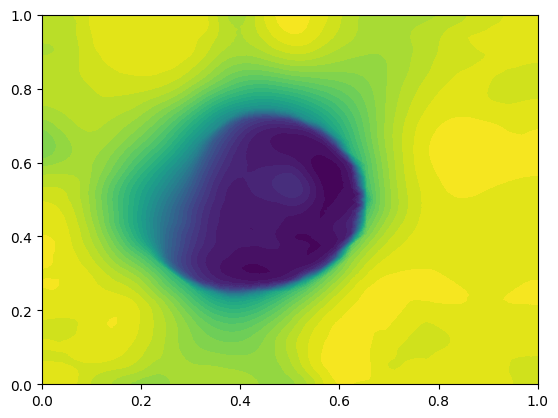

In [24]:
firedrake.tricontourf(q_γ, 40);

Finally, let's see how well our approximation matches the true value:

In [25]:
assemble(abs(q_true - q_γ) * dx) / assemble(abs(q_true) * dx)

0.4724208132289417

Next let's see what happens when we use a much smaller value of the envelope parameter.
If you run this code yourself, you can observe first-hand how the problem gets much more ill-conditioned as you decrease $\gamma$ by how much longer it takes to get a solution!

In [26]:
Γ = Constant(10)

J = assemble(
    0.5 * ((u - u_obs) / σ)**2 * dx +
    α * huber(grad(q), α * Γ) * dx
)

q̂ = Control(q)
Ĵ = ReducedFunctional(J, q̂)
inverse_problem = MinimizationProblem(Ĵ)
inverse_solver = ROLSolver(inverse_problem, rol_options, inner_product="L2")
q_Γ = inverse_solver.solve()


Quasi-Newton Method with Limited-Memory BFGS
Line Search: Cubic Interpolation satisfying Strong Wolfe Conditions
  iter  value          gnorm          snorm          #fval     #grad     ls_#fval  ls_#grad  
  0     9.201092e-01   1.952120e+00   


  1     9.192954e-01   3.925307e+00   1.368570e-03   6         2         5         0         


  2     9.181541e-01   2.858703e+00   6.002670e-04   7         3         1         0         


  3     9.173060e-01   3.407027e+00   9.038273e-04   8         4         1         0         


  4     9.165049e-01   3.088967e+00   8.344842e-04   9         5         1         0         


  5     9.155086e-01   3.367667e+00   1.802026e-03   10        6         1         0         


  6     9.147250e-01   3.189786e+00   6.960527e-04   11        7         1         0         


  7     9.138162e-01   3.121670e+00   1.030484e-03   12        8         1         0         


  8     9.129130e-01   3.609008e+00   1.490854e-03   13        9         1         0         


  9     9.119663e-01   3.419873e+00   1.499215e-03   14        10        1         0         


  10    9.110886e-01   3.043739e+00   9.847610e-04   15        11        1         0         


  11    9.101993e-01   3.249977e+00   1.362103e-03   16        12        1         0         


  12    9.093541e-01   3.560176e+00   1.555442e-03   17        13        1         0         


  13    9.084881e-01   2.954051e+00   1.100730e-03   18        14        1         0         


  14    9.076311e-01   3.233596e+00   1.426928e-03   19        15        1         0         


  15    9.069074e-01   3.450832e+00   1.263646e-03   20        16        1         0         


  16    9.061056e-01   2.842830e+00   1.083955e-03   21        17        1         0         


  17    9.051901e-01   3.208690e+00   1.707365e-03   22        18        1         0         


  18    9.044066e-01   3.573767e+00   1.611884e-03   23        19        1         0         


  19    9.036206e-01   2.971243e+00   1.108587e-03   24        20        1         0         


  20    9.027863e-01   3.065649e+00   1.409932e-03   25        21        1         0         


  21    9.020708e-01   3.294885e+00   1.260697e-03   26        22        1         0         


  22    9.012995e-01   2.854537e+00   1.328558e-03   27        23        1         0         


  23    9.005328e-01   3.244047e+00   1.688330e-03   28        24        1         0         


  24    8.998841e-01   3.113954e+00   1.065326e-03   29        25        1         0         


  25    8.992587e-01   2.610329e+00   9.316870e-04   30        26        1         0         


  26    8.985217e-01   2.996881e+00   1.689117e-03   31        27        1         0         


  27    8.979459e-01   3.415261e+00   1.491425e-03   32        28        1         0         


  28    8.973625e-01   2.512175e+00   5.896435e-04   33        29        1         0         


  29    8.966870e-01   2.599034e+00   1.588816e-03   34        30        1         0         


  30    8.962073e-01   2.981792e+00   1.142153e-03   35        31        1         0         


  31    8.956982e-01   2.357758e+00   9.759552e-04   36        32        1         0         


  32    8.950764e-01   2.654877e+00   1.898474e-03   37        33        1         0         


  33    8.946408e-01   3.169571e+00   1.133230e-03   38        34        1         0         


  34    8.942182e-01   2.260495e+00   5.043822e-04   39        35        1         0         


  35    8.936434e-01   2.279055e+00   1.467281e-03   40        36        1         0         


  36    8.932603e-01   2.728722e+00   9.377188e-04   41        37        1         0         


  37    8.927991e-01   2.196969e+00   1.230159e-03   42        38        1         0         


  38    8.923419e-01   2.479017e+00   1.540805e-03   43        39        1         0         


  39    8.919726e-01   2.326312e+00   9.902132e-04   44        40        1         0         


  40    8.916344e-01   2.001780e+00   7.610054e-04   45        41        1         0         


  41    8.911893e-01   2.392217e+00   1.575039e-03   46        42        1         0         


  42    8.908828e-01   2.827840e+00   1.076623e-03   47        43        1         0         


  43    8.906011e-01   1.841951e+00   3.626014e-04   48        44        1         0         


  44    8.902400e-01   1.698881e+00   1.125189e-03   49        45        1         0         


  45    8.899753e-01   2.064723e+00   9.313165e-04   50        46        1         0         


  46    8.896059e-01   2.139254e+00   1.691956e-03   51        47        1         0         


  47    8.892714e-01   2.368419e+00   1.286841e-03   52        48        1         0         


  48    8.889547e-01   1.826613e+00   5.774252e-04   53        49        1         0         


  49    8.886308e-01   1.887213e+00   1.056318e-03   54        50        1         0         


  50    8.883451e-01   2.328604e+00   1.314702e-03   55        51        1         0         


  51    8.880553e-01   1.768100e+00   7.897908e-04   56        52        1         0         


  52    8.877570e-01   1.787903e+00   1.140683e-03   57        53        1         0         


  53    8.874899e-01   2.203676e+00   1.061058e-03   58        54        1         0         


  54    8.871788e-01   1.853344e+00   1.139987e-03   59        55        1         0         


  55    8.868503e-01   1.998137e+00   1.322642e-03   60        56        1         0         


  56    8.865543e-01   2.108155e+00   1.234031e-03   61        57        1         0         


  57    8.862570e-01   1.820962e+00   8.759849e-04   62        58        1         0         


  58    8.859210e-01   1.994702e+00   1.360699e-03   63        59        1         0         


  59    8.856386e-01   2.289652e+00   1.161950e-03   64        60        1         0         


  60    8.853656e-01   1.731277e+00   7.001791e-04   65        61        1         0         


  61    8.850349e-01   1.757196e+00   1.317291e-03   66        62        1         0         


  62    8.847813e-01   2.421783e+00   1.193164e-03   67        63        1         0         


  63    8.845161e-01   1.705357e+00   7.401279e-04   68        64        1         0         


  64    8.842367e-01   1.643121e+00   1.083747e-03   69        65        1         0         


  65    8.840150e-01   1.990816e+00   8.574313e-04   70        66        1         0         


  66    8.837461e-01   1.727795e+00   1.129609e-03   71        67        1         0         


  67    8.834451e-01   2.168944e+00   1.605825e-03   72        68        1         0         


  68    8.831739e-01   1.931298e+00   9.917571e-04   73        69        1         0         


  69    8.829315e-01   1.659779e+00   6.045715e-04   74        70        1         0         


  70    8.825890e-01   2.159970e+00   1.528452e-03   75        71        1         0         


  71    8.823389e-01   2.537922e+00   1.593834e-03   76        72        1         0         


  72    8.820989e-01   1.732727e+00   2.855152e-04   77        73        1         0         


  73    8.817528e-01   1.634204e+00   1.395703e-03   78        74        1         0         


  74    8.815278e-01   2.131409e+00   1.148534e-03   79        75        1         0         


  75    8.812407e-01   1.693036e+00   1.199863e-03   80        76        1         0         


  76    8.809346e-01   2.125317e+00   1.974744e-03   81        77        1         0         


  77    8.806758e-01   2.090595e+00   1.201093e-03   82        78        1         0         


  78    8.804464e-01   1.650831e+00   3.773135e-04   83        79        1         0         


  79    8.801155e-01   1.759318e+00   1.533765e-03   84        80        1         0         


  80    8.798965e-01   2.653948e+00   1.819160e-03   85        81        1         0         


  81    8.796592e-01   1.714712e+00   4.960861e-04   86        82        1         0         


  82    8.793393e-01   1.655540e+00   1.418463e-03   87        83        1         0         


  83    8.791023e-01   1.953709e+00   1.296753e-03   88        84        1         0         


  84    8.787815e-01   2.318060e+00   2.607364e-03   89        85        1         0         


  85    8.784848e-01   2.050291e+00   8.547556e-04   90        86        1         0         


  86    8.782281e-01   1.693928e+00   6.460027e-04   91        87        1         0         


  87    8.779394e-01   1.959806e+00   1.478998e-03   92        88        1         0         


  88    8.776743e-01   2.486102e+00   2.012069e-03   93        89        1         0         


  89    8.773974e-01   1.754040e+00   9.867058e-04   94        90        1         0         


  90    8.770684e-01   1.770271e+00   1.754683e-03   95        91        1         0         


  91    8.768215e-01   2.351507e+00   1.320560e-03   96        92        1         0         


  92    8.765129e-01   1.870601e+00   1.513337e-03   97        93        1         0         


  93    8.761423e-01   2.071801e+00   2.135921e-03   98        94        1         0         


  94    8.758640e-01   2.497005e+00   1.697084e-03   99        95        1         0         


  95    8.755859e-01   1.851110e+00   6.819622e-04   100       96        1         0         


  96    8.751893e-01   1.864360e+00   2.013647e-03   101       97        1         0         


  97    8.749341e-01   2.534827e+00   1.501460e-03   102       98        1         0         


  98    8.746378e-01   1.948077e+00   1.143211e-03   103       99        1         0         


  99    8.742210e-01   2.136105e+00   2.590160e-03   104       100       1         0         


  100   8.739736e-01   2.671688e+00   1.304692e-03   105       101       1         0         


  101   8.737219e-01   1.868887e+00   3.537450e-04   106       102       1         0         


  102   8.733333e-01   1.867961e+00   2.395907e-03   107       103       1         0         


  103   8.730949e-01   2.391069e+00   7.752677e-04   108       104       1         0         


  104   8.728034e-01   1.811071e+00   1.228349e-03   109       105       1         0         


  105   8.724188e-01   1.880194e+00   2.455265e-03   110       106       1         0         


  106   8.721215e-01   2.585256e+00   1.338129e-03   111       107       1         0         


  107   8.717793e-01   2.027751e+00   1.718478e-03   112       108       1         0         


  108   8.713766e-01   2.214916e+00   2.697480e-03   113       109       1         0         


  109   8.710966e-01   2.442535e+00   1.139259e-03   114       110       1         0         


  110   8.708123e-01   1.904367e+00   1.156716e-03   115       111       1         0         


  111   8.703889e-01   2.102265e+00   2.328690e-03   116       112       1         0         


  112   8.701047e-01   2.590719e+00   2.156832e-03   117       113       1         0         


  113   8.698054e-01   1.992979e+00   1.296752e-03   118       114       1         0         


  114   8.693790e-01   2.094138e+00   2.313126e-03   119       115       1         0         


  115   8.691200e-01   2.730997e+00   1.895791e-03   120       116       1         0         


  116   8.688338e-01   2.058765e+00   7.910314e-04   121       117       1         0         


  117   8.683568e-01   2.046779e+00   3.217005e-03   122       118       1         0         


  118   8.681115e-01   2.539570e+00   1.516939e-03   123       119       1         0         


  119   8.678376e-01   1.937740e+00   1.003297e-03   124       120       1         0         


  120   8.674260e-01   2.094539e+00   2.917491e-03   125       121       1         0         


  121   8.671949e-01   2.727746e+00   1.019751e-03   126       122       1         0         


  122   8.669461e-01   1.946342e+00   6.028760e-04   127       123       1         0         


  123   8.665321e-01   1.920296e+00   3.109782e-03   128       124       1         0         


  124   8.662981e-01   2.148575e+00   6.689989e-04   129       125       1         0         


  125   8.659860e-01   1.834953e+00   1.741182e-03   130       126       1         0         


  126   8.656510e-01   2.511412e+00   2.750581e-03   131       127       1         0         


  127   8.653817e-01   2.005032e+00   1.110769e-03   132       128       1         0         


  128   8.651723e-01   1.721009e+00   8.229871e-04   133       129       1         0         


  129   8.648451e-01   1.958286e+00   1.921386e-03   134       130       1         0         


  130   8.646721e-01   2.810799e+00   2.341890e-03   135       131       1         0         


  131   8.644516e-01   1.588437e+00   2.038995e-04   136       132       1         0         


  132   8.642157e-01   1.468322e+00   1.035469e-03   137       133       1         0         


  133   8.640278e-01   1.679952e+00   8.969157e-04   138       134       1         0         


  134   8.638219e-01   3.165744e+00   2.668994e-03   139       135       1         0         


  135   8.635246e-01   1.646349e+00   8.989342e-04   140       136       1         0         


  136   8.633474e-01   1.502686e+00   2.158875e-04   141       137       1         0         


  137   8.631148e-01   1.761900e+00   1.567184e-03   142       138       1         0         


  138   8.628817e-01   2.590912e+00   2.110584e-03   143       139       1         0         


  139   8.626289e-01   1.767852e+00   9.199116e-04   144       140       1         0         


  140   8.623962e-01   1.613619e+00   1.164305e-03   145       141       1         0         


  141   8.621905e-01   1.790819e+00   1.273102e-03   146       142       1         0         


  142   8.619426e-01   1.951070e+00   1.995191e-03   147       143       1         0         


  143   8.617122e-01   1.752351e+00   1.170761e-03   148       144       1         0         


  144   8.614924e-01   1.542456e+00   1.054677e-03   149       145       1         0         


  145   8.612697e-01   1.802288e+00   1.368014e-03   150       146       1         0         


  146   8.610539e-01   1.788424e+00   1.635391e-03   151       147       1         0         


  147   8.608506e-01   1.513623e+00   1.000589e-03   152       148       1         0         


  148   8.606312e-01   1.563091e+00   9.794825e-04   153       149       1         0         


  149   8.604507e-01   1.756196e+00   1.254116e-03   154       150       1         0         


  150   8.602631e-01   1.378342e+00   9.706898e-04   155       151       1         0         


  151   8.600486e-01   1.538593e+00   1.471903e-03   156       152       1         0         


  152   8.598850e-01   1.831043e+00   1.499130e-03   157       153       1         0         


  153   8.597200e-01   1.373669e+00   6.518331e-04   158       154       1         0         


  154   8.594988e-01   1.446739e+00   1.429446e-03   159       155       1         0         


  155   8.593489e-01   1.869531e+00   1.287513e-03   160       156       1         0         


  156   8.591821e-01   1.381910e+00   6.578353e-04   161       157       1         0         


  157   8.589569e-01   1.452278e+00   1.568364e-03   162       158       1         0         


  158   8.588202e-01   1.954675e+00   1.313904e-03   163       159       1         0         


  159   8.586769e-01   1.398890e+00   3.889270e-04   164       160       1         0         


  160   8.584542e-01   1.379365e+00   1.617802e-03   165       161       1         0         


  161   8.583301e-01   1.708032e+00   6.152220e-04   166       162       1         0         


  162   8.581831e-01   1.309286e+00   9.028863e-04   167       163       1         0         


  163   8.579855e-01   1.432528e+00   1.624624e-03   168       164       1         0         


  164   8.578445e-01   1.723094e+00   1.117068e-03   169       165       1         0         


  165   8.576915e-01   1.419651e+00   9.555006e-04   170       166       1         0         


  166   8.574704e-01   1.791437e+00   2.162871e-03   171       167       1         0         


  167   8.573274e-01   1.968616e+00   1.090810e-03   172       168       1         0         


  168   8.572030e-01   1.338312e+00   1.435691e-04   173       169       1         0         


  169   8.570019e-01   1.170790e+00   1.200389e-03   174       170       1         0         


  170   8.568605e-01   1.503628e+00   9.977873e-04   175       171       1         0         


  171   8.566749e-01   1.520875e+00   1.729052e-03   176       172       1         0         


  172   8.564874e-01   1.620982e+00   1.994569e-03   177       173       1         0         


  173   8.562875e-01   1.445612e+00   1.107694e-03   178       174       1         0         


  174   8.561164e-01   1.589756e+00   1.018041e-03   179       175       1         0         


  175   8.559423e-01   1.406057e+00   1.321706e-03   180       176       1         0         


  176   8.557456e-01   1.383792e+00   1.493785e-03   181       177       1         0         


  177   8.555442e-01   1.836984e+00   1.841486e-03   182       178       1         0         


  178   8.553480e-01   1.531160e+00   1.320072e-03   183       179       1         0         


  179   8.551442e-01   1.421386e+00   1.231913e-03   184       180       1         0         


  180   8.549235e-01   1.918136e+00   2.036302e-03   185       181       1         0         


  181   8.547062e-01   1.752133e+00   1.416931e-03   186       182       1         0         


  182   8.544982e-01   1.448789e+00   9.505095e-04   187       183       1         0         


  183   8.542535e-01   1.839751e+00   2.164895e-03   188       184       1         0         


  184   8.540589e-01   2.047111e+00   1.800522e-03   189       185       1         0         


  185   8.538674e-01   1.500476e+00   4.040269e-04   190       186       1         0         


  186   8.536064e-01   1.587639e+00   1.979434e-03   191       187       1         0         


  187   8.534498e-01   1.971428e+00   1.265868e-03   192       188       1         0         


  188   8.532718e-01   1.452277e+00   6.623810e-04   193       189       1         0         


  189   8.530044e-01   1.532343e+00   2.386719e-03   194       190       1         0         


  190   8.528573e-01   2.154609e+00   1.029616e-03   195       191       1         0         


  191   8.526961e-01   1.393499e+00   3.303329e-04   196       192       1         0         


  192   8.524818e-01   1.350518e+00   1.772921e-03   197       193       1         0         


  193   8.523333e-01   1.573138e+00   5.162063e-04   198       194       1         0         


  194   8.521155e-01   1.612042e+00   1.923631e-03   199       195       1         0         


  195   8.519228e-01   1.723619e+00   2.130108e-03   200       196       1         0         


  196   8.517653e-01   1.375614e+00   3.392543e-04   201       197       1         0         


  197   8.515889e-01   1.343175e+00   1.187884e-03   202       198       1         0         


  198   8.513544e-01   1.937990e+00   2.344256e-03   203       199       1         0         


  199   8.511544e-01   1.887212e+00   1.875276e-03   204       200       1         0         


  200   8.509708e-01   1.414618e+00   8.556156e-04   205       201       1         0         


  201   8.507446e-01   1.561950e+00   1.764496e-03   206       202       1         0         


  202   8.505839e-01   2.017131e+00   1.563412e-03   207       203       1         0         


  203   8.504019e-01   1.516455e+00   1.030790e-03   208       204       1         0         


  204   8.501530e-01   1.689806e+00   2.289040e-03   209       205       1         0         


  205   8.499976e-01   2.065417e+00   1.198829e-03   210       206       1         0         


  206   8.498391e-01   1.503006e+00   6.687638e-04   211       207       1         0         


  207   8.495575e-01   1.470963e+00   2.395600e-03   212       208       1         0         


  208   8.493886e-01   1.943184e+00   1.478809e-03   213       209       1         0         


  209   8.491863e-01   1.590072e+00   1.575412e-03   214       210       1         0         


  210   8.489208e-01   1.924168e+00   2.685140e-03   215       211       1         0         


  211   8.487265e-01   1.942847e+00   1.685269e-03   216       212       1         0         


  212   8.485550e-01   1.497010e+00   2.712576e-04   217       213       1         0         


  213   8.482581e-01   1.559918e+00   2.006178e-03   218       214       1         0         


  214   8.481033e-01   2.466898e+00   2.195889e-03   219       215       1         0         


  215   8.479264e-01   1.506460e+00   6.863155e-04   220       216       1         0         


  216   8.477030e-01   1.367941e+00   1.664653e-03   221       217       1         0         


  217   8.475586e-01   1.515876e+00   1.016934e-03   222       218       1         0         


  218   8.473270e-01   2.414858e+00   2.891040e-03   223       219       1         0         


  219   8.471160e-01   1.805892e+00   1.402169e-03   224       220       1         0         


  220   8.469820e-01   1.356985e+00   3.799058e-04   225       221       1         0         


  221   8.467634e-01   1.445681e+00   1.569927e-03   226       222       1         0         


  222   8.465819e-01   1.928228e+00   1.905877e-03   227       223       1         0         


  223   8.464011e-01   1.355878e+00   1.355765e-03   228       224       1         0         


  224   8.461886e-01   1.348095e+00   2.500310e-03   229       225       1         0         


  225   8.460037e-01   2.168914e+00   2.025227e-03   230       226       1         0         


  226   8.458014e-01   1.524263e+00   1.168733e-03   231       227       1         0         


  227   8.456080e-01   1.285068e+00   9.262184e-04   232       228       1         0         


  228   8.454479e-01   1.529438e+00   1.411274e-03   233       229       1         0         


  229   8.452584e-01   1.557755e+00   1.760112e-03   234       230       1         0         


  230   8.450714e-01   1.470566e+00   1.057155e-03   235       231       1         0         


  231   8.449036e-01   1.393349e+00   1.316688e-03   236       232       1         0         


  232   8.447361e-01   1.377026e+00   1.451619e-03   237       233       1         0         


  233   8.445562e-01   1.752193e+00   1.536496e-03   238       234       1         0         


  234   8.443798e-01   1.494972e+00   1.454580e-03   239       235       1         0         


  235   8.442210e-01   1.312091e+00   1.172526e-03   240       236       1         0         


  236   8.440275e-01   1.847296e+00   1.980653e-03   241       237       1         0         


  237   8.438543e-01   1.529913e+00   1.729456e-03   242       238       1         0         


  238   8.437057e-01   1.312141e+00   8.717521e-04   243       239       1         0         


  239   8.434814e-01   1.621259e+00   2.281214e-03   244       240       1         0         


  240   8.433374e-01   2.424734e+00   2.253335e-03   245       241       1         0         


  241   8.431743e-01   1.409987e+00   2.797835e-04   246       242       1         0         


  242   8.429834e-01   1.300768e+00   1.472924e-03   247       243       1         0         


  243   8.428417e-01   1.437707e+00   1.152153e-03   248       244       1         0         


  244   8.426614e-01   2.847127e+00   3.591487e-03   249       245       1         0         


  245   8.424288e-01   1.458019e+00   1.089968e-03   250       246       1         0         


  246   8.423037e-01   1.262745e+00   1.738766e-04   251       247       1         0         


  247   8.420928e-01   1.504114e+00   2.210626e-03   252       248       1         0         


  248   8.419476e-01   2.641148e+00   2.618031e-03   253       249       1         0         


  249   8.417492e-01   1.358987e+00   7.407771e-04   254       250       1         0         


  250   8.415992e-01   1.277410e+00   1.232950e-03   255       251       1         0         


  251   8.414534e-01   1.466238e+00   1.481166e-03   256       252       1         0         


  252   8.412775e-01   2.132362e+00   3.114361e-03   257       253       1         0         


  253   8.410908e-01   1.571294e+00   8.421484e-04   258       254       1         0         


  254   8.409445e-01   1.253415e+00   3.893618e-04   259       255       1         0         


  255   8.407669e-01   1.484434e+00   1.757521e-03   260       256       1         0         


  256   8.406152e-01   1.874250e+00   1.990768e-03   261       257       1         0         


  257   8.404622e-01   1.265104e+00   6.596876e-04   262       258       1         0         


  258   8.402927e-01   1.196514e+00   1.551109e-03   263       259       1         0         


  259   8.401624e-01   1.500966e+00   9.323316e-04   264       260       1         0         


  260   8.399933e-01   1.304225e+00   1.539484e-03   265       261       1         0         


  261   8.398363e-01   1.603789e+00   1.946679e-03   266       262       1         0         


  262   8.396837e-01   1.254322e+00   9.559988e-04   267       263       1         0         


  263   8.395387e-01   1.210637e+00   9.544158e-04   268       264       1         0         


  264   8.393757e-01   1.676525e+00   2.043566e-03   269       265       1         0         


  265   8.392169e-01   1.389472e+00   1.623666e-03   270       266       1         0         


  266   8.390743e-01   1.205654e+00   8.147986e-04   271       267       1         0         


  267   8.389203e-01   1.461748e+00   1.343522e-03   272       268       1         0         


  268   8.387881e-01   1.666394e+00   1.371583e-03   273       269       1         0         


  269   8.386606e-01   1.188333e+00   4.049582e-04   274       270       1         0         


  270   8.384971e-01   1.248861e+00   1.884524e-03   275       271       1         0         


  271   8.383851e-01   1.683006e+00   9.615402e-04   276       272       1         0         


  272   8.382657e-01   1.154563e+00   7.787357e-04   277       273       1         0         


  273   8.381340e-01   1.105308e+00   1.350334e-03   278       274       1         0         


  274   8.380269e-01   1.442965e+00   1.018189e-03   279       275       1         0         


  275   8.379044e-01   1.221706e+00   1.313650e-03   280       276       1         0         


  276   8.377835e-01   1.194551e+00   1.035579e-03   281       277       1         0         


  277   8.376818e-01   1.162045e+00   8.304192e-04   282       278       1         0         


  278   8.375766e-01   1.087956e+00   8.547299e-04   283       279       1         0         


  279   8.374504e-01   1.402667e+00   1.532743e-03   284       280       1         0         


  280   8.373454e-01   1.393188e+00   9.869205e-04   285       281       1         0         


  281   8.372581e-01   1.017699e+00   3.624681e-04   286       282       1         0         


  282   8.371405e-01   1.044726e+00   1.142941e-03   287       283       1         0         


  283   8.370489e-01   1.544400e+00   1.445320e-03   288       284       1         0         


  284   8.369443e-01   1.111495e+00   6.655736e-04   289       285       1         0         


  285   8.368195e-01   1.074517e+00   1.413182e-03   290       286       1         0         


  286   8.367365e-01   1.435409e+00   9.473653e-04   291       287       1         0         


  287   8.366459e-01   1.034874e+00   6.036674e-04   292       288       1         0         


  288   8.365296e-01   1.069672e+00   1.432621e-03   293       289       1         0         


  289   8.364492e-01   1.398349e+00   8.289424e-04   294       290       1         0         


  290   8.363613e-01   1.059758e+00   6.054124e-04   295       291       1         0         


  291   8.362378e-01   1.120255e+00   1.703699e-03   296       292       1         0         


  292   8.361569e-01   1.496334e+00   1.277757e-03   297       293       1         0         


  293   8.360707e-01   1.094999e+00   4.916184e-04   298       294       1         0         


  294   8.359475e-01   1.069131e+00   1.582230e-03   299       295       1         0         


  295   8.358768e-01   1.406548e+00   8.167465e-04   300       296       1         0         


  296   8.357991e-01   1.006531e+00   4.781959e-04   301       297       1         0         


  297   8.356831e-01   9.968494e-01   1.483799e-03   302       298       1         0         


  298   8.356071e-01   1.281485e+00   9.062621e-04   303       299       1         0         


  299   8.355222e-01   9.598793e-01   6.953577e-04   304       300       1         0         


  300   8.354272e-01   9.977103e-01   1.316285e-03   305       301       1         0         


  301   8.353591e-01   1.161103e+00   7.450334e-04   306       302       1         0         


  302   8.352942e-01   8.764703e-01   3.478023e-04   307       303       1         0         


  303   8.352112e-01   8.620006e-01   9.615695e-04   308       304       1         0         


  304   8.351528e-01   1.133382e+00   8.081513e-04   309       305       1         0         


  305   8.350910e-01   8.683249e-01   5.207640e-04   310       306       1         0         


  306   8.350128e-01   8.954262e-01   9.980896e-04   311       307       1         0         


  307   8.349574e-01   1.068870e+00   8.399392e-04   312       308       1         0         


  308   8.348968e-01   8.585661e-01   5.767430e-04   313       309       1         0         


  309   8.348009e-01   1.035423e+00   1.609076e-03   314       310       1         0         


  310   8.347403e-01   1.295862e+00   9.689939e-04   315       311       1         0         


  311   8.346799e-01   8.906881e-01   2.497717e-04   316       312       1         0         


  312   8.345837e-01   8.307664e-01   1.139683e-03   317       313       1         0         


  313   8.345258e-01   1.105583e+00   8.187479e-04   318       314       1         0         


  314   8.344492e-01   9.299352e-01   1.004300e-03   319       315       1         0         


  315   8.343630e-01   1.317594e+00   1.523116e-03   320       316       1         0         


  316   8.342862e-01   9.643723e-01   7.448080e-04   321       317       1         0         


  317   8.342336e-01   8.146449e-01   2.489657e-04   322       318       1         0         


  318   8.341491e-01   9.640969e-01   1.159066e-03   323       319       1         0         


  319   8.341110e-01   1.586606e+00   1.234270e-03   324       320       1         0         


  320   8.340525e-01   7.738716e-01   3.552169e-04   325       321       1         0         


  321   8.340076e-01   6.381554e-01   4.006934e-04   326       322       1         0         


  322   8.339676e-01   7.521618e-01   4.087373e-04   327       323       1         0         


  323   8.339068e-01   1.334450e+00   1.257851e-03   328       324       1         0         


  324   8.338476e-01   9.421258e-01   9.013090e-04   329       325       1         0         


  325   8.338050e-01   6.621084e-01   8.733129e-05   330       326       1         0         
Optimization Terminated with Status: Step Tolerance Met


The resulting solution gives a substantially better fit to the true parameters.

In [27]:
assemble(abs(q_true - q_Γ) * dx) / assemble(abs(q_true) * dx)

0.28965905881412063

Moreover, the interface is noticeably much sharper when we decrease $\gamma$, as expected.

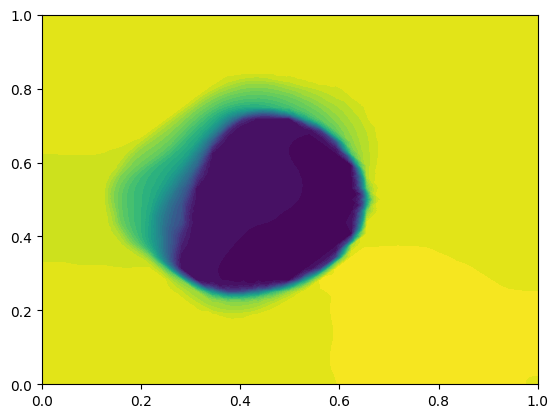

In [28]:
firedrake.tricontourf(q_Γ, 40);

At a few points, the mesh triangles have made themselves apparent.
To fix this, we would want to either adapt the mesh to the contours of $q$, or do things the blunt way and uniformly refine until this effect was no longer obvious.

### Discussion

Regularization of inverse problems is a subtle topic.
When the field we're inferring has sharp discontinuities, the total variation functional can be a better regularizer than the mean square gradient.
There's a statistical way to make that argument more precise: TV better represents the prior information that we're claiming to have about our solution.
Using it incurs a cost in implementation complexity, however, because the TV functional is non-smooth.
As with the obstacle problem, the Moreau envelope provides us with a way to solve non-smooth optimization problems using tools that were designed only for smooth ones.

We've examined what regularization functional to use here, but we haven't examined the topic of deciding how much to regularize.
There are several procedures for choosing a value of $\alpha$, some merely heuristic and others based on deeper insights from Bayesian statistical inference.
In the statistical literature this is often referred to as *hyperparameter optimization* and it's arguably just as important as deciding which regularization functional to use in the first place.